# MSM Forecasting Jupyter Notebook

This notebook follows the original script, with section comments migrated to Markdown cells and code comments preserved.

# 1. Setup, Data Loading, and Preprocessing




### 1.1. Load necessary libraries and supress warnings

warning supression is needed for a statsmodels warning about date indexes.

In [1]:
import os
import sys
import joblib
import warnings
import numpy as np
import pandas as pd

from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression


In [ ]:
csv_path = "data/historical_snapshots/"
notebook_path = os.path.abspath('')
repo_root = os.path.abspath(os.path.join(notebook_path, '..'))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

if "google.colab" in sys.modules:
    colab_path = "/content/models-regimes-trend"
    csv_path =  colab_path + "/" + csv_path
    if not os.path.exists(colab_path):
        !git clone https://github.com/internQuant/models-regimes-trend.git
    %cd models-regimes-trend
    !apt-get install git-lfs
    !git lfs install
    !git lfs pull
    sys.path.insert(0, colab_path)

from utils.data import *
from utils.misc import *
from utils.msm import *
from utils.plots import *
from utils.transforms import *
from utils.presentation import style_panel

np.set_printoptions(precision=4, suppress=True)

warnings.filterwarnings(
    "ignore",
    message=(
        "A date index has been provided, but it has no associated frequency "
        "information and so will be ignored when e.g. forecasting\."
    ),
    category=ValueWarning,
    module=r"statsmodels\.tsa\.base\.tsa_model"
)


### 1.3. Load Data

#### Choose the data source

You can choose between using the provided snapshot or fetching the latest data using the FFScraper helper class.

> Uncomment below to fetch the latest data.

In [ ]:

# data_source = FFScraper()
# returns = data_source.daily_data['mkt-rf'][:'2024-08'].copy().squeeze()

> Comment below if using latest data snapshot as mentioned above

In [6]:
# Comment this if using latest data snapshot as mentioned above
returns = read_ff_daily_csv(csv_path + "ff_data_daily_202410_snapshot.csv")[:'2024-08']

### 1.4. Preprocess Data

Compute moving averages and create lagged returns.

In [ ]:
sma_returns = compute_moving_averages(returns)
ma_lags_rets = sma_returns.shift(1).dropna()

returns_working_sample = returns['1943':].copy().rename('Unconditional')
returns_subsample      = returns['1943':'1999'].copy().rename('Unconditional')

lagged_returns = (
    returns
    .to_frame('l0')
    .assign(l1=returns.shift(1), l2=returns.shift(2))
    .dropna()
)


In [10]:
returns_working_sample = returns['1943':].copy().rename('Unconditional')
returns_subsample      = returns['1943':'1999'].copy().rename('Unconditional')

lagged_returns = (
    returns
    .to_frame('l0')
    .assign(l1=returns.shift(1), l2=returns.shift(2))
    .dropna()
)


----
## 2. Fit First MSM and forecast a month ahead

Estimate a 3-regime AR(2) Markov-Switching model on the subsample (from 1943 up until 1999).

### 2.1. Define the msm args that will be used to fit the model and fit it

In [11]:
msm_kwargs = dict(
    k_regimes=3,
    order=2,
    switching_ar=True,
    switching_trend=True,
    switching_variance=True
)

first_msm = MarkovAutoregression(returns_subsample, **msm_kwargs)
first_msm_fit = first_msm.fit(maxiter=300)
msm_stats = MSMParamClassifier(first_msm_fit.params)


In [12]:
msm_stats

================ MSM Param Classifier(k=3) =================
Regime   |          μ |          σ | AR       1 | AR       2
------------------------------------------------------------
bull     |    0.00111 |    0.00404 |    0.22626 |   -0.11248
bear     |   -0.00254 |    0.01796 |    0.10395 |   -0.06364
chop     |   -0.00004 |    0.00758 |    0.19843 |   -0.05262

Transition matrix P (bull, bear, chop):
  0.9610   0.0000   0.0390
  0.0000   0.9151   0.0849
  0.0325   0.0121   0.9553

regime_map: {'bull': 0, 'bear': 2, 'chop': 1}

### 2.2. Forecast First Period

Forecast returns and regime probabilities for January 2000 without refitting the model.


#### 2.2.1 Prepare data needed for forecasting:
- Period to be forecasted
- Lagged returns
- Filtered probabilities from the MSM fit
- Actual returns for filtering/updating the probabilities along the way

In [13]:
forecast_period = '2000-01'
frcst_idx = lagged_returns.loc[forecast_period].index
first_msm_filtered_probs = first_msm_fit.filtered_marginal_probabilities
last_probs = first_msm_filtered_probs.iloc[-1].values[msm_stats.order]
obs = lagged_returns.loc[forecast_period, 'l0'].values.reshape(-1,1)

#### 2.2.2. Estimate returns in each regime along the month

- For each day in the forecast period, we estimate the expected return in each regime using an AR(2) (autoregressive of order 2) model.
- This means that the return forecast for each regime depends on the previous two observed returns, with regime-specific coefficients (intercept and AR terms) learned from the MSM fit. 
- The process is repeated for all three regimes (bull, bear, chop), producing a matrix of regime-conditional forecasts for the month.

In [ ]:
forecasted_regime_returns = ar2_forecast(
    msm_stats.mus,
    msm_stats.ars[0],
    msm_stats.ars[1],
    lagged_returns.loc[forecast_period, 'l1'].values.reshape(-1,1),
    lagged_returns.loc[forecast_period, 'l2'].values.reshape(-1,1)
)
print(forecasted_regime_returns)

[[ 0.0022 -0.0021  0.0009]
 [-0.0011 -0.0036 -0.0017]
 [-0.0073 -0.0063 -0.0077]
 [ 0.0055 -0.0001  0.0019]
 [-0.0004 -0.0032 -0.0014]
 [ 0.0092  0.0013  0.0067]
 [ 0.0015 -0.0028  0.0018]
 [-0.0047 -0.0054 -0.0044]
 [ 0.0015 -0.0022 -0.0005]
 [ 0.0055 -0.0004  0.0035]
 [ 0.0019 -0.0024  0.0014]
 [-0.0008 -0.0035 -0.0012]
 [ 0.0024 -0.0019  0.001 ]
 [-0.0002 -0.0032 -0.001 ]
 [ 0.002  -0.0021  0.0006]
 [-0.005  -0.0054 -0.0053]
 [ 0.0051 -0.0004  0.0023]
 [-0.0004 -0.0033 -0.0012]
 [ 0.0006 -0.0027 -0.0007]
 [-0.0048 -0.0052 -0.0054]]


#### 2.2.3. Obtain forecasted filtered and updated probabilities

- **Updated probabilities contain information about the actual returns of each observation, therefore a trader could not anticipate it and use it as a trading signal.**
- **The filtered probabilities are the ones that could be used as a trading signal, as they are based on the model fit and not on the actual returns.**

The Hamilton filter is an iterative algorithm used in Markov-switching models to estimate the probability of being in each regime at each time step, given observed data up to that point. The process involves two main steps for each new observation:

1. **Prediction (Filtering):**  
    Compute the probability of being in each regime at time *t*, given all information up to time *t-1*. This uses the transition matrix and the filtered probabilities from the previous step.

2. **Update:**  
    Incorporate the new observation at time *t* to update the regime probabilities. This is done by weighting the predicted probabilities by the likelihood of the new observation under each regime, then normalizing.

In practice, this update is applied iteratively for each observation in the time series, producing a sequence of filtered probabilities that reflect the model's evolving belief about the current regime. The filtered probabilities are forward-looking and can be used for real-time forecasting or trading signals.

In [17]:

f_fltd_probs, f_updt_probs = compute_probability_forecasts(
    observations      = obs,
    forecasted_values = forecasted_regime_returns,
    sigmas            = msm_stats.sig,
    init_probs        = last_probs,
    P                 = msm_stats.P
)

#### 2.2.4. Plot updated forecasted probabilities

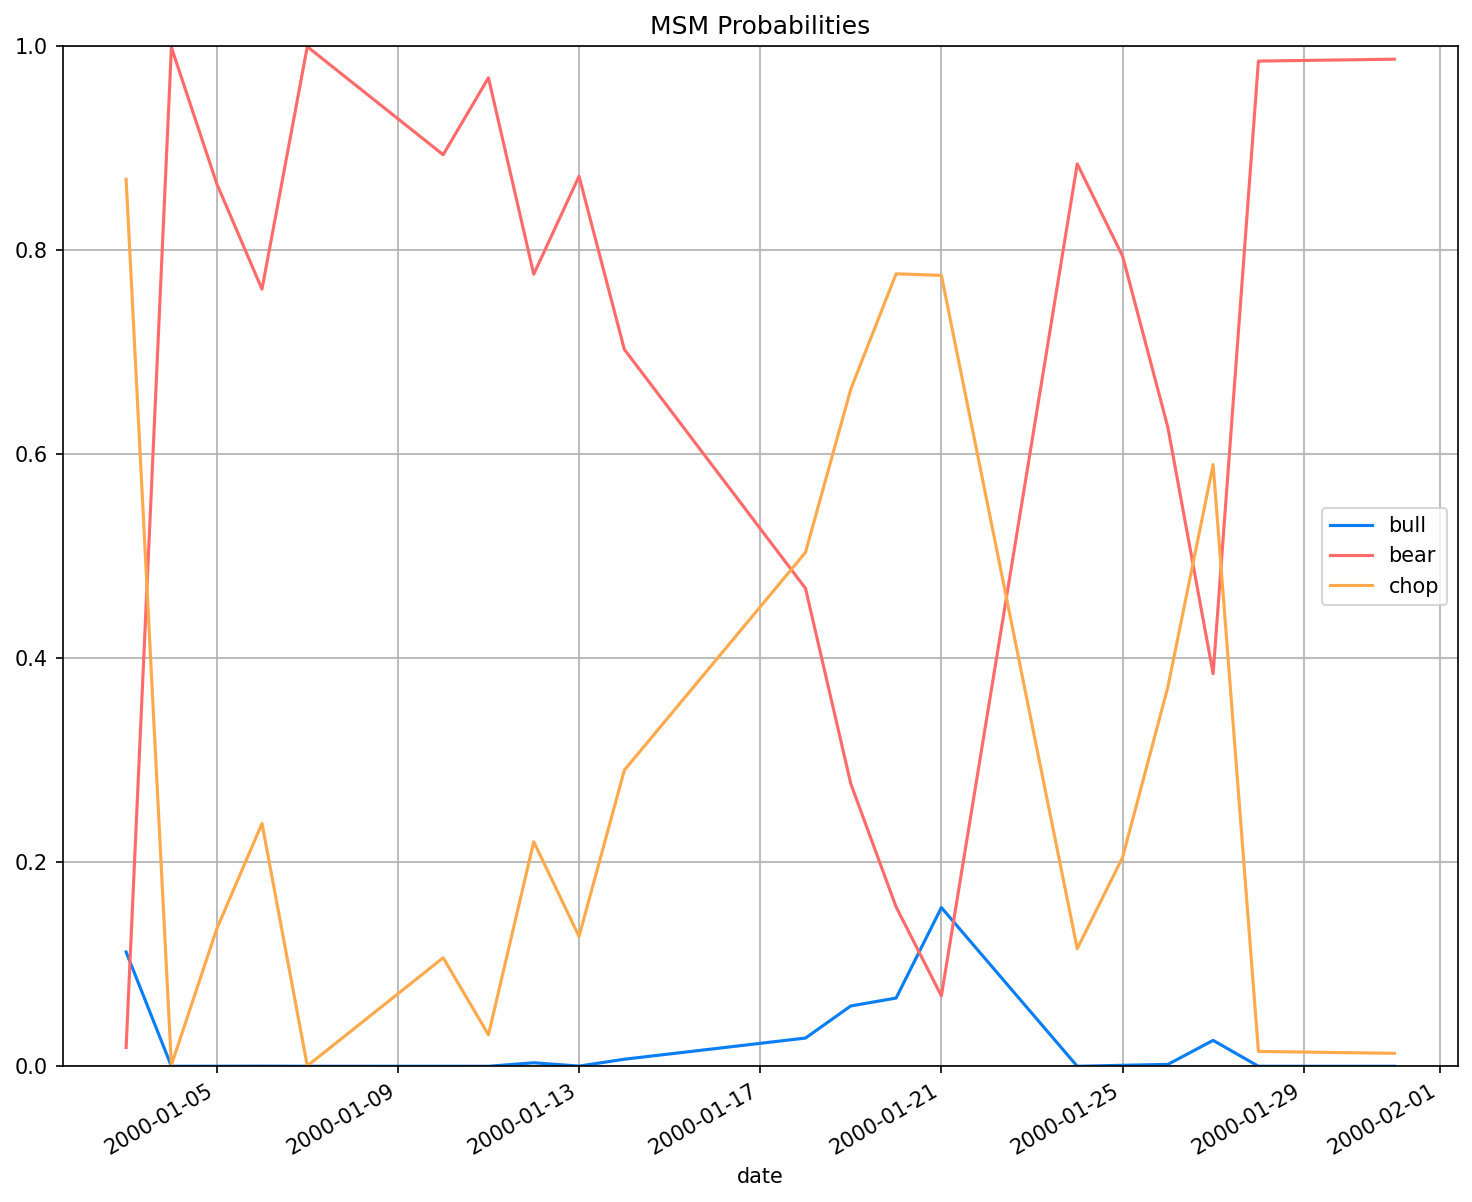

In [18]:
# Plot probabilities
forecasted_upd_probs = pd.DataFrame(f_updt_probs, frcst_idx)
forecasted_upd_probs.columns = ['bull', 'bear', 'chop']
ax = forecasted_upd_probs.plot(figsize=(12,10), title='MSM Probabilities')
ax.set_ylim(0, 1)
ax.grid(True)

#### 2.2.5. Forecast volatility and returns

In Markov-Switching Models (MSMs), both volatility and return forecasts are computed as probability-weighted averages across regimes. Each regime has its own mean (expected return) and standard deviation (volatility), estimated from the data.

- **Return Forecast:**  
    The expected return at each time step is calculated as the sum of the regime-specific return forecasts, each weighted by the filtered probability of being in that regime. This produces a single, forward-looking return forecast that accounts for regime uncertainty.

- **Volatility Forecast:**  
    Similarly, the forecasted volatility is computed as the probability-weighted sum of the regime-specific volatilities. This reflects the model's uncertainty about which regime will prevail, resulting in a dynamic volatility estimate that adapts as regime probabilities change.

This approach allows MSMs to capture shifts in both the level and variability of returns, providing more realistic forecasts in environments where market regimes change over time.

In [19]:
forecasted_vol = forecast_MSM_vol(f_fltd_probs, msm_stats.mus, msm_stats.sig)
forecasted_vol = pd.Series(forecasted_vol, index=frcst_idx)
forecasted_return = pd.Series(
    np.sum(forecasted_regime_returns * f_fltd_probs, axis=1), frcst_idx
)

#### 2.2.6. Offline Forecast

- This approach does not use the actual observed returns from the market during the forecast period. 
- Instead, it recursively feeds the model's own previous forecasts back into the AR(2) process for each step. 
- As a result, the forecast is generated entirely "offline," without incorporating new real-world information as it becomes available. 
- This contrasts with the online (filtered) approach, which updates regime probabilities and forecasts using actual observed returns.

In [20]:
y1 = returns['1999-12-31']
y2 = returns['1999-12-30']
off_forecast = ar2_msm_forecast(msm_stats, last_probs, y1, y2, len(frcst_idx))

fltd_probs = off_forecast['filtered_probs']
off_vol = forecast_MSM_vol(fltd_probs, msm_stats.mus, msm_stats.sig)
off_forecasted_returns = pd.Series(off_forecast['mixture_forecast'], frcst_idx)


#### 2.2.7. Plot Forecasts

Compare online and offline forecasts visually.

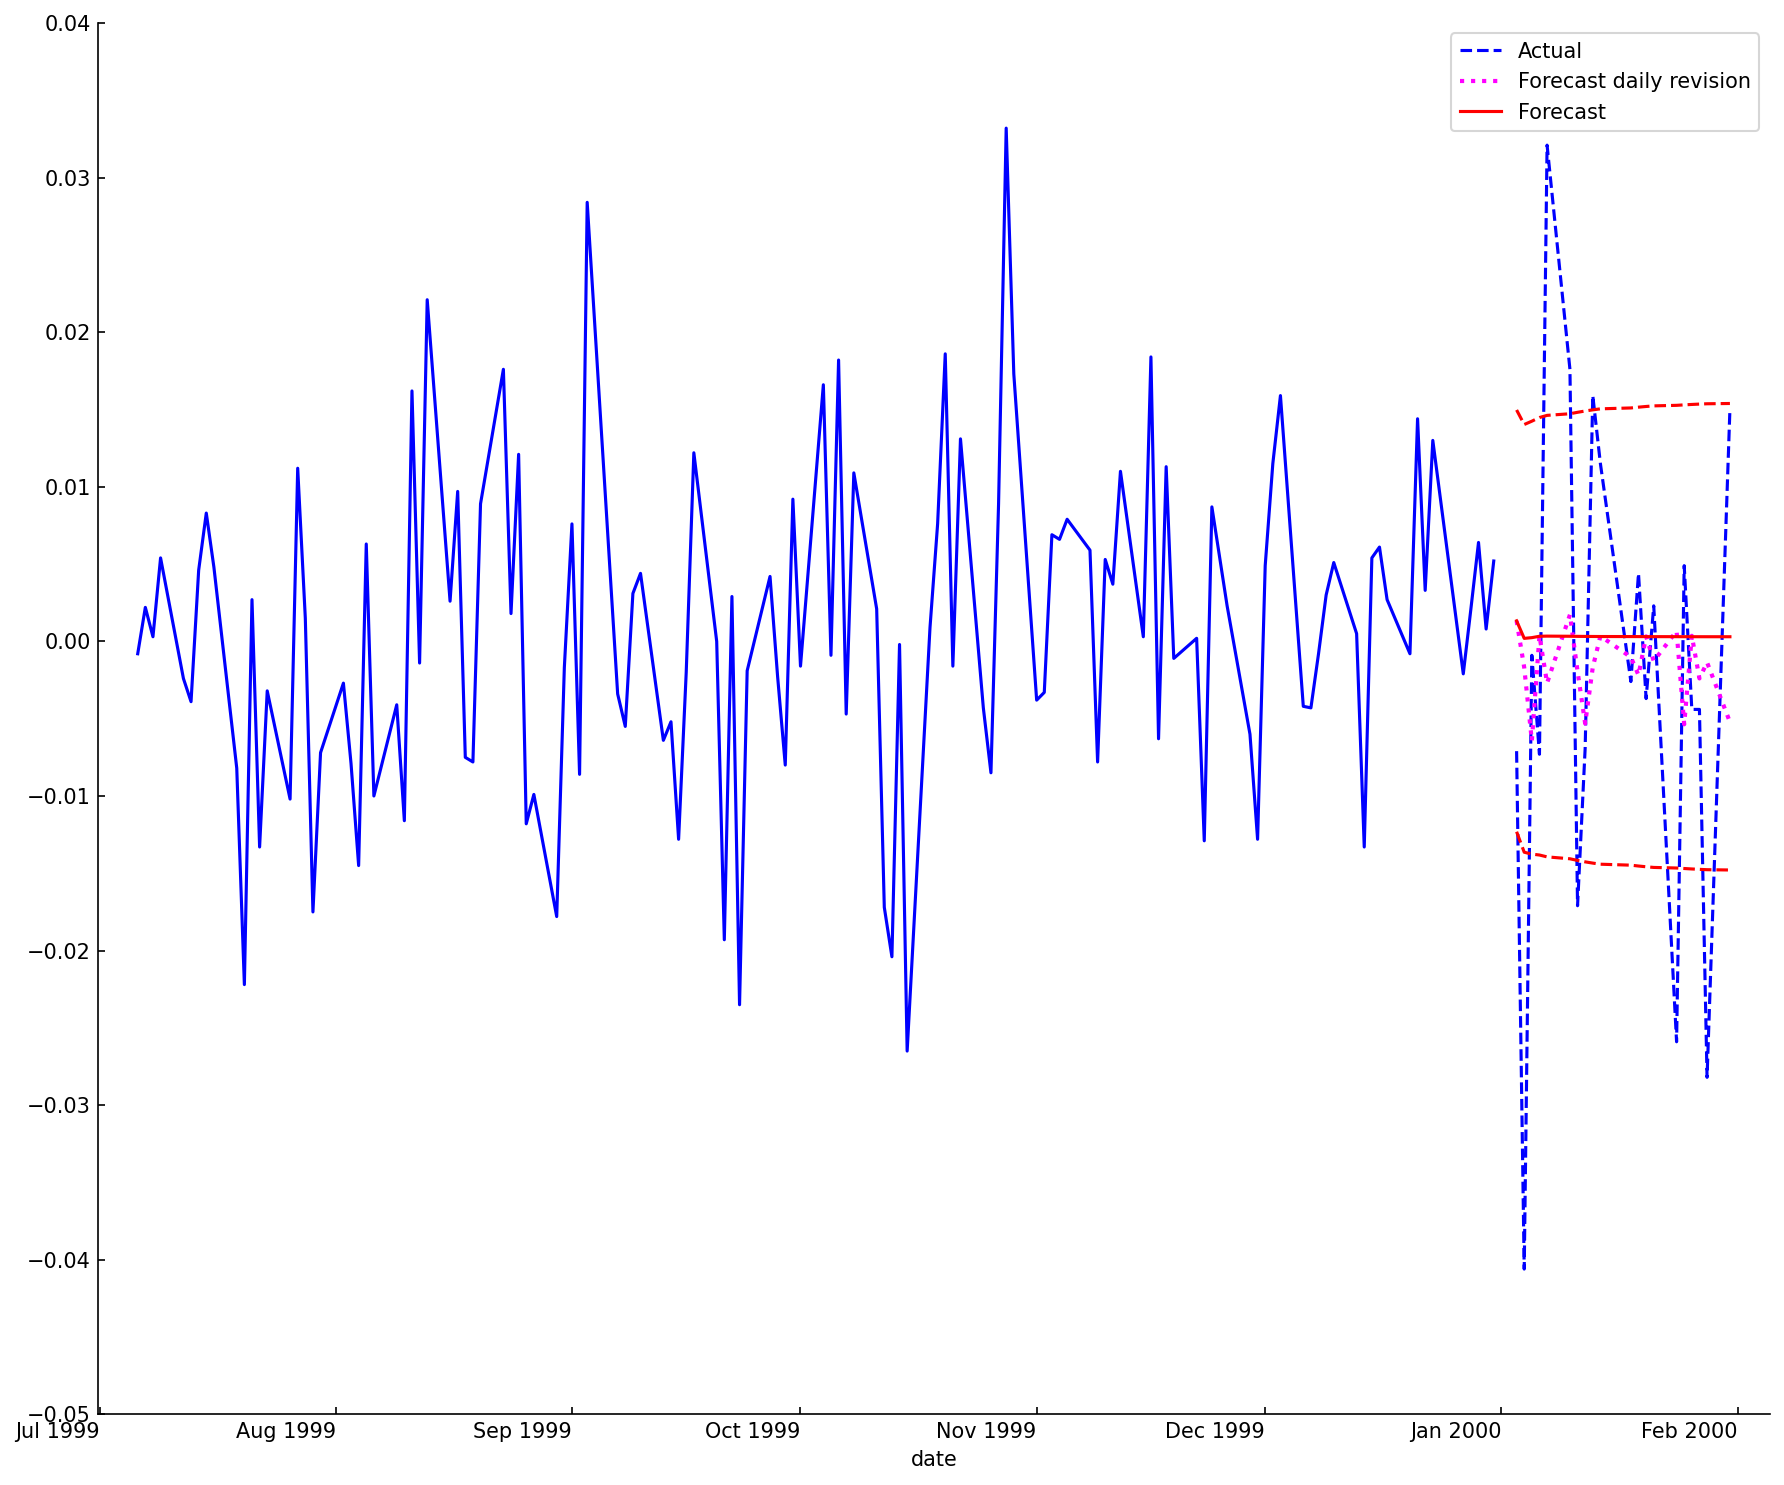

In [21]:
plot_forecasts(
    returns['1999-07-03':'1999'],
    returns['2000-01'],
    forecasted_return,
    off_forecasted_returns,
    off_vol
)


----
## 3. The Expanding MSM Fitter (Optional)

Fit MSM models on an expanding window. This can be time and resource intensive.

The `ExpandingMSMARFitter` class automates the process of fitting Markov-Switching Autoregressive (MSM-AR) models on an expanding window basis across a univariate time series.

- This step is optional. It is recommended to first follow along with the notebook using the provided pre-computed results. 

**Uncomment and run the code below to fit MSM models on an expanding window across the entire sample.**

**This process fits a new MSM model each month from the start of the forecast period (2000-01) through 2024-08, saving each model's results in a dictionary keyed by the training cutoff date. The fitting process is computationally intensive, it required approximately 10 hours to complete on an AMD Ryzen 7 7800X3D, 64GB RAM machine.**

It is strongly recommended to use the provided pre-computed checkpoint for initial exploration. Once you are comfortable with the workflow, you can experiment with your own parameter choices by running the code below.


In [ ]:
# Uncomment below to run the ExpandingMSMARFitter over the entire period.
# fitter = ExpandingMSMARFitter(
#     data=returns_working_sample,
#     start_date='1999-12',
#     end_date='2024-08',
#     freq='M',
#     verbose=True,
#     logger=logger
# )
# fitter.run()

In [ ]:
# To save raw results:
# joblib.dump(fitter.results, "raw_msm_results_1943-99_2024_snapshot.joblib")

In [ ]:
# To convert to lightweight results:
# lite_results = convert_msmar_results(fitter.results)
# joblib.dump(lite_results, "data/baked/lite_msm_results_1943-99_2024_snapshot.joblib")

## 3.1. Load the pre-computed results

- Run this without commenting the code below to load the pre-computed results.


In [22]:

# Load lightweight results:
lite_results = joblib.load("data/baked/lite_msm_results_1943-99_2024_snapshot.joblib")

----
## 4. MSM & Random Forest Forecasting and Strategy Construction

Prepare the fitted MSM results for forecasting and strategy construction.

In [24]:
# Prepare the results DataFrame
msm_results_df = pd.Series(lite_results, name='results').to_frame()
msm_results_df.index.name = 'training_cutoff'
msm_results_df.sort_index(inplace=True)

# Add forecast_period column
fc_per = (msm_results_df.index + pd.offsets.MonthEnd(1))
msm_results_df['forecast_period'] = fc_per.strftime("%Y-%m").unique()
msm_results_df.head()

,results,forecast_period
training_cutoff,,
1999-12-31,"<MSMARResultsLite filtered.shape=(14681, 3) sm...",2000-01
2000-01-31,"<MSMARResultsLite filtered.shape=(14701, 3) sm...",2000-02
2000-02-29,"<MSMARResultsLite filtered.shape=(14721, 3) sm...",2000-03
2000-03-31,"<MSMARResultsLite filtered.shape=(14744, 3) sm...",2000-04
2000-04-30,"<MSMARResultsLite filtered.shape=(14763, 3) sm...",2000-05


### 4.1. Set our Random Forest parameters
- Provided set offers a balance between model complexity, speed and culture.

In [25]:
rf_kwargs = dict(
    n_estimators      = 420,
    random_state      = 69,
    n_jobs            = -1,
    max_depth         = 10,
    max_features      = 'sqrt',
    min_samples_split = 5,
    min_samples_leaf  = 5,
)

### 4.2. Run the main forecasting function

**This step takes approximately 7 minutes to run on an AMD Ryzen 7 7800X3D, 64GB RAM machine.**

- This function uses the fitted MSM results to forecast returns, volatility, and regime probabilities between each month fit.
- This includes the training and forecasting of a Random Forest model to predict regime probabilities as described in the original white paper.
- The Random Forest model is trained on the lagged filtered probabilities and moving averages of the returns and squared returns, with a target of the smoothed regime probabilities from the MSM fit.

In [26]:

# Run forecasting with RFC
forecasted_data = forecast_msm_rfc(
    msm_results_df,
    lagged_returns,
    ma_lags_rets,
    rf_kwargs
)

Forecasting loop: 100%|██████████| 296/296 [05:28<00:00,  1.11s/month]


----
## 5. Fit an MSM model on the entire sample, compare its filtered probabilities with the real time forecasted ones

- Builds a confusion matrix with both full sample and real-time forecasted probabilities.

In [28]:

# Full-sample MSM for confusion matrix
full_sample_msm = MarkovAutoregression(returns_working_sample, **msm_kwargs)
full_msm_fit  = full_sample_msm.fit(maxiter=300)
full_stats  = MSMParamClassifier(full_msm_fit.params)
full_fltd_probs = full_msm_fit.filtered_marginal_probabilities[full_stats.order]
full_fltd_probs.columns = ['bull','bear','chop']

The confusion matrix below demonstrates that this replication achieves slightly better regime identification compared to the original whitepaper results, this is due to what I can only assume different implementations of the MSM-AR in Python(this approach) and the paper's software being used(looks like its MATLAB) particularly in detecting bear regimes. Improved bear regime classification likely contributed to the enhanced performance of "no bear" strategies observed in later analyses.

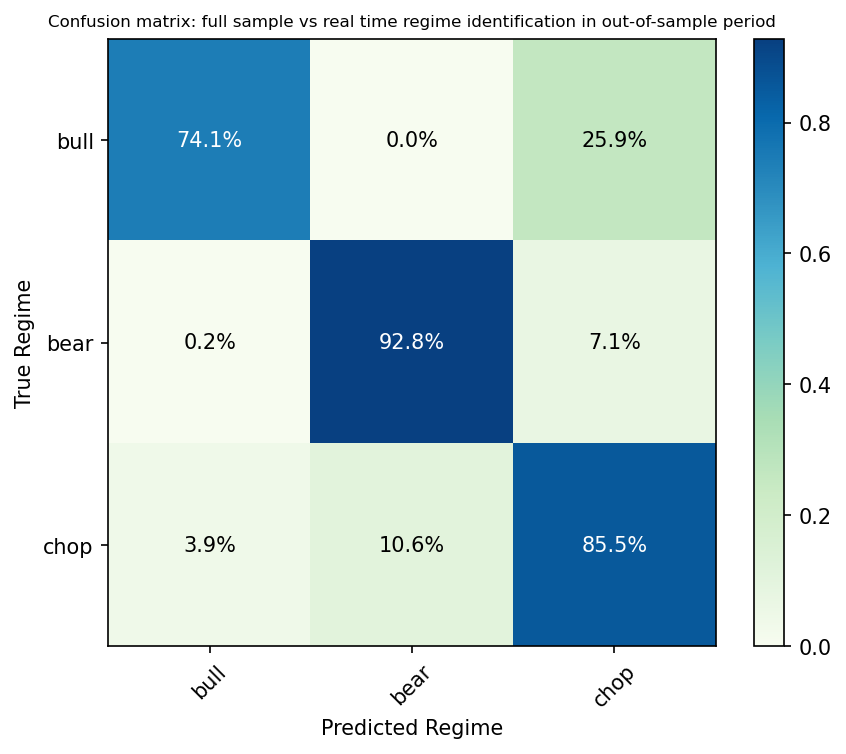

In [29]:

ground_truth = full_fltd_probs.idxmax(axis=1).loc[forecasted_data['filtered_probs'].index]
forecasted_regimes = forecasted_data['filtered_probs'].idxmax(axis=1).dropna()
ground_truth = ground_truth.loc[forecasted_regimes.index]
plot_confusion_matrix(ground_truth, forecasted_regimes)


----
## 6. Construction of signals, strategies and their returns.

#### We start by computing signals of TSM strategies for benchmarking.
- This is done via the `TSMEngine` class previously used in this series of replications.
- Returns here are not exactly equal as the original paper, i have included a few suspicions i have as to why this is the case at the end of the notebook.

In [30]:

TSME = TSMEngine(returns_working_sample, lookback_list=[21,63,126,252])
TSM_signals = TSME.signals.replace(-1,0).dropna()
TSM_signals['tsm_avg'] = TSM_signals.mean(axis=1)
idx = forecasted_data['filtered_probs'].index

### 6.1. Obtain forecasted volatility, returns and no bear signals

- Use the forecasted volatility to scale positions, then rescale to annual 15% vol ex-post.
- The forecasted returns signals obtained where pretty weak in comparison to the original paper.

In [31]:

forecast_vol_signals = (0.15/(forecasted_data['vol']*np.sqrt(252))).rename('VM')
forecast_returns_signals = np.sign(forecasted_data['returns']).rename('Pos. Forecast')
nb_msm_signals = probability_threshold_signals(forecasted_data['filtered_probs'])
nb_rfc_signals = probability_threshold_signals(forecasted_data['rforest_probs'])
nb_rfc_signals.columns = 'RF_' + nb_rfc_signals.columns


### 6.2. Obtain mix of forecasted and TSM signals

In [32]:

nb_msm_tsm_avg_signals = nb_msm_signals.mul(TSM_signals['tsm_avg'], axis=0)
nb_msm_tsm_avg_signals.columns = 'TSM_avg_' + nb_msm_tsm_avg_signals.columns
nb_rfc_tsm_avg_signals = nb_rfc_signals.mul(TSM_signals['tsm_avg'], axis=0)
nb_rfc_tsm_avg_signals.columns = 'TSM_avg_' + nb_rfc_tsm_avg_signals.columns


- Putting everything together...

In [34]:

strategies_weights = pd.concat([
    (returns_working_sample*0)+1,
    TSM_signals,
    forecast_vol_signals,
    forecast_returns_signals,
    nb_msm_signals,
    nb_msm_tsm_avg_signals,
    nb_rfc_signals,
    nb_rfc_tsm_avg_signals,
], axis=1).dropna()


### 6.3. Return calculations
The original paper does not specify the exact methodology for calculating returns of the final strategies. In this replication, we simply scale daily returns to target weights, and then to target volatility ex-post. Whilst taking care to avoid look-ahead bias. However, in real-world trading and backtesting, additional factors such as turnover, transaction costs, and rebalancing frequency must be considered. For daily rebalancing strategies executed at market on close, returns should ideally account for intraday price movements, slippage, and execution timing. Thus, actual realized returns may differ from those obtained by naively scaling the original daily return series.

In [ ]:

strategies_returns = strategies_weights.mul(returns_working_sample.loc[idx], axis=0)
strategies_returns_vol_adj = strategies_returns.mul(0.15/(strategies_returns.std()*np.sqrt(252)))
all_metrics = part4_format_metrics(strategies_returns_vol_adj, trading_days=252)


----
## 7. Metrics and Takeaways

- The metrics displayed in the panels are not exactly identical to those reported in the original white paper, but they closely track the published results.
- As discussed above, the fitted MSMs in this replication tend to classify bear regimes more accurately, which generally leads to improved performance for strategies that avoid bear regimes.
- It is important to note that these results do not account for transaction costs or rebalancing frictions, which would impact real-world performance.

In [ ]:

panel_titles = {
    'A': 'Panel A: Benchmark strategies',
    'B': 'Panel B: Strategies using MSM forecasts',
    'C': 'Panel C: Strategies combining TSM and MSM',
    'D': 'Panel D: Strategies using random forests trained on MSM regimes'
}
panelA = style_panel(all_metrics.iloc[:6], panel_titles['A'])
panelB = style_panel(all_metrics.iloc[6:11], panel_titles['B'])
panelC = style_panel(all_metrics.iloc[11:14], panel_titles['C'])
panelD = style_panel(all_metrics.iloc[14:], panel_titles['D'])

for panel in [panelA, panelB, panelC, panelD]:
    display(panel)


,Annual excess return (%),Volatility (%),Sharpe ratio,Max Drawdown (%)
Unconditional,5.83,15.00,0.39,-47.40
tsm_21,4.96,15.00,0.33,-52.33
tsm_63,6.47,15.00,0.43,-50.30
tsm_126,7.73,15.00,0.52,-38.22
tsm_252,6.69,15.00,0.45,-33.48
tsm_avg,7.52,15.00,0.50,-39.34


,Annual excess return (%),Volatility (%),Sharpe ratio,Max Drawdown (%)
VM,6.37,15.00,0.42,-46.17
Pos. Forecast,-0.93,15.00,-0.06,-69.47
no_bear_5%,7.91,15.00,0.53,-33.83
no_bear_10%,8.19,15.00,0.55,-32.12
no_bear_20%,8.41,15.00,0.56,-34.32


,Annual excess return (%),Volatility (%),Sharpe ratio,Max Drawdown (%)
TSM_avg_no_bear_5%,8.05,15.00,0.54,-27.91
TSM_avg_no_bear_10%,8.50,15.00,0.57,-24.47
TSM_avg_no_bear_20%,8.50,15.00,0.57,-24.98


,Annual excess return (%),Volatility (%),Sharpe ratio,Max Drawdown (%)
RF_no_bear_5%,8.95,15.00,0.60,-25.35
RF_no_bear_10%,6.90,15.00,0.46,-47.59
RF_no_bear_20%,6.87,15.00,0.46,-38.34
TSM_avg_RF_no_bear_5%,8.58,15.00,0.57,-28.16
TSM_avg_RF_no_bear_10%,7.53,15.00,0.50,-33.30
TSM_avg_RF_no_bear_20%,7.84,15.00,0.52,-30.08


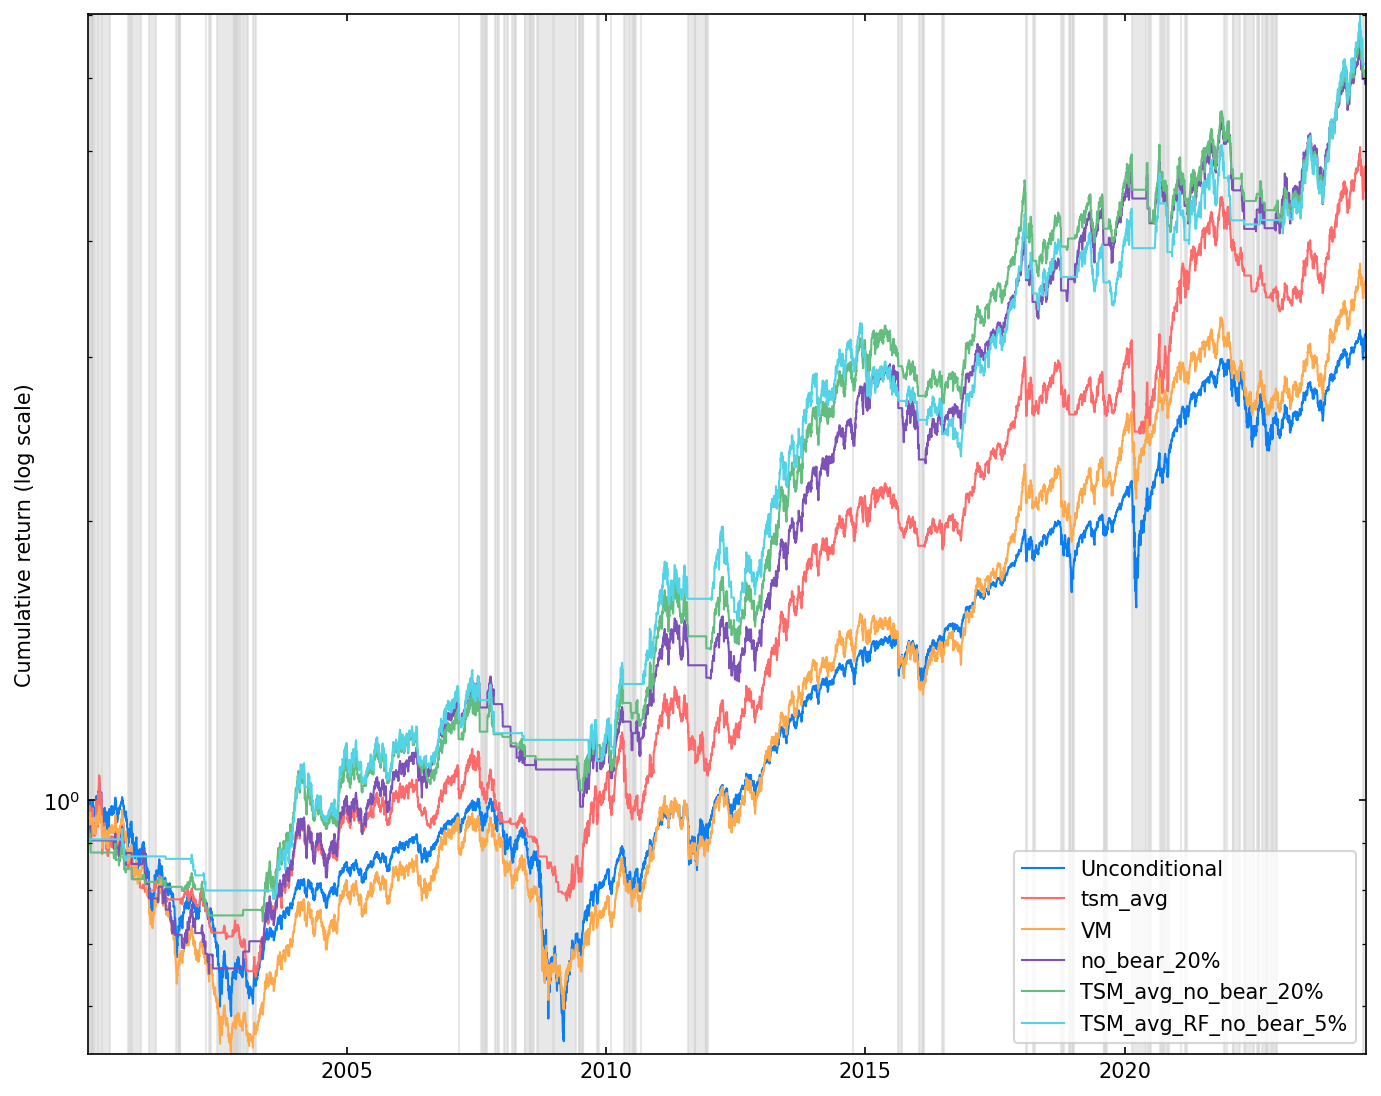

In [ ]:
strats_of_interest = [
    'Unconditional',
    'tsm_avg',
    'VM',
    'no_bear_20%',
    'TSM_avg_no_bear_20%',
    'TSM_avg_RF_no_bear_5%',
]
is_bear_regime = ground_truth == 'bear'
select_strats = strategies_returns_vol_adj[strats_of_interest]
cumulative_plot_shaded(select_strats, is_bear_regime)

----

## 8. Conclusion, Acknowledgements and Special Thanks

With this notebook, we conclude the series of replications of Jungle Rock's "Models, Regimes and Trend Following" series. Feel free to reach out with any questions, comments, critiques or suggestions.

- First and foremost, I would like to thank ***Frank***, ***Alex*** and the ***entire Jungle Rock team*** for providing these excellent white papers.

- Secondly, I would like to thank everyone who has tagged along with this series of replications, liking, sharing and commenting on the work. Your support is greatly appreciated and I hope you found this series as interesting and fun as I did making it.

----